0.030926227569580078


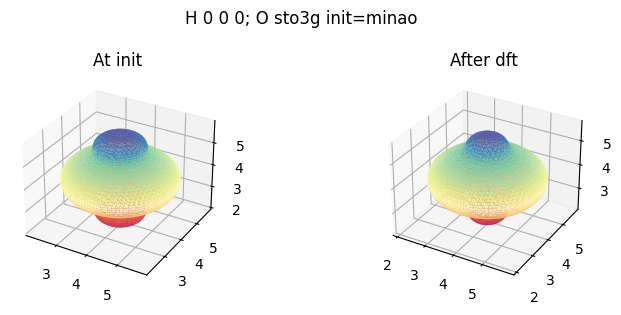

0.0710597038269043


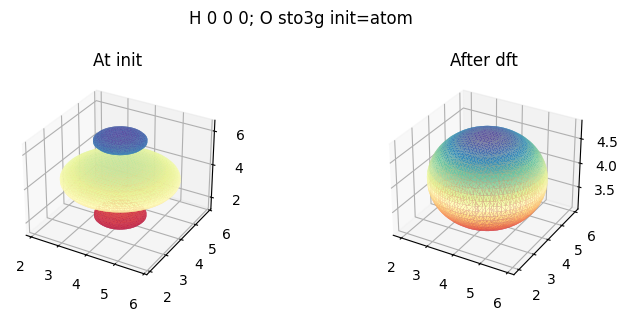

0.026896953582763672


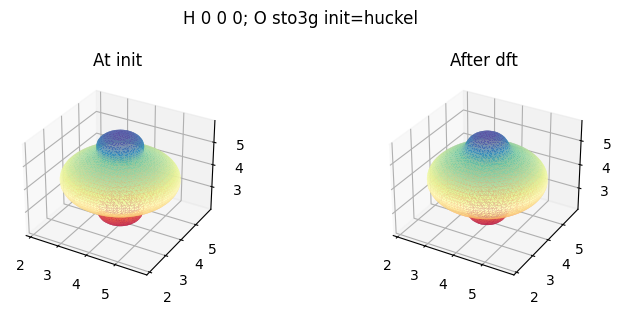

0.0011305809020996094


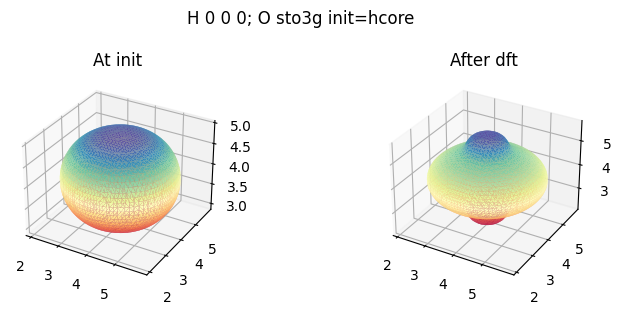

In [124]:
# todo1 
# [ ] plot different isosurfaces on top of each other 
# [ ] figure out how to save to jpg (this allows making visualizasiton)
# [ ] compare different initialization and different converged electron densities. 
# [ ] compare same molecule with different basis set
# [ ]

import os
os.environ['OMP_NUM_THREADS'] = '29'
from pyscf.tools import cubegen
import numpy as np
from numpy import cos, pi
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_dm(mol, dms, string, basis, init, normalize=500):

  fig, ax = plt.subplots(1, len(dms), subplot_kw={"projection": "3d"}, figsize=(8, 3))

  plt.suptitle("%s %s init=%s"%(string[:10], basis, init))

  for i, dm in enumerate(dms): 
    a = cubegen.density(mol, "h2.cube", dm)  # tou
    x, y, z = pi*np.mgrid[-1:1:80j, -1:1:80j, -1:1:80j]
    vol = a/a.sum()# cos(x) + cos(y) + cos(z)
    iso_val=vol.max()/normalize
    verts, faces, _, _ = marching_cubes(vol, iso_val, spacing=(0.1, 0.1, 0.1))

    #fig = plt.figure(figsize=(4,4))
    #ax = fig.add_subplot(111, projection='3d')
    ax[i].plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], cmap='Spectral', lw=1)
  ax[0].set_title("At init")
  ax[1].set_title("After dft")
  plt.tight_layout()
  plt.show()

def plot_string(string, basis="631g*", init= "hcore", normalize=500):
  from pyscf import gto, scf
  #mol = gto.M(atom='C 0 0 0; O 0 0 1;', basis='sto3g')
  mol = gto.M(atom=string, basis=basis)
  mf = scf.RKS(mol)
  mf.verbose = 0 
  mf.xc = "lda"
  mf.init_guess = init
  import time 
  t0 = time.time()
  dms = [mf.get_init_guess(mol, key=init)]
  print(time.time()-t0)
  mf.kernel()
  dms.append( mf.make_rdm1())
  plot_dm(mol, dms, string, basis, init, normalize=normalize)

plot_string("H 0 0 0; O 0 0 1; H 0 0 2;", basis="sto3g", init="minao")
plot_string("H 0 0 0; O 0 0 2; H 0 0 4;", basis="sto3g", init="atom") # <-- this looks like it also works! 
plot_string("H 0 0 0; O 0 0 1; H 0 0 2;", basis="sto3g", init="huckel")
plot_string("H 0 0 0; O 0 0 1; H 0 0 2;", basis="sto3g", init="hcore")

In [114]:
#args.smiles = pd.read_parquet("gdb/gdb12/gdb12_sorted.parquet")["smiles"].values # takes ~ 30s to load? 
#print(time.time()-t0)
#print(args.smiles)

angstrom_to_bohr = 1.88973
import re 

def get_atom_string(atoms, locs):
    atom_string = atoms 
    atoms = re.findall('[a-zA-Z][^A-Z]*', atoms)
    str = ""
    for atom, loc in zip(atoms, locs): 
      str += "%s %4f %4f %4f; "%((atom,) + tuple(loc) )
    return atom_string, str 

#if args.gdb == 10: args.smiles = [a.split("\t")[0] for a in open("gdb/gdb11_size10.smi", "r").read().split("\n")]
#if args.gdb == 10: args.smiles = [a for a in open("gdb/gdb11_size10_sorted.csv", "r").read().split("\n")]
##if args.gdb == 9:  args.smiles = [a.split("\t")[0] for a in open("gdb/gdb11_size09.smi", "r").read().split("\n")]
#if args.gdb == 9:  args.smiles = [a for a in open("gdb/gdb11_size09_sorted.csv", "r").read().split("\n")]
#if args.gdb == 7:  args.smiles = [a for a in open("gdb/gdb11_size07_sorted.csv", "r").read().split("\n")]
#if args.gdb == 8:  args.smiles = [a for a in open("gdb/gdb11_size08_sorted.csv", "r").read().split("\n")]
#if args.gdb == 5:  args.smiles = [a.split("\t")[0] for a in open("gdb/gdb11_size05.smi", "r").read().split("\n")]
smiles = [a for a in open("gdb/gdb11_size05_sorted.csv", "r").read().split("\n")]

smile = smiles[123]

#atoms = [a for a in list(smile) if a == "C" or a == "N" or a == "O" or a == "F"] #+ ["H"]
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import AllChem
b = Chem.MolFromSmiles(smile)
b = Chem.AddHs(b)  # perhaps more numerically stable wiht the H's? e.g. energy may be lower?;; main problem with this is memory? 
atoms = [atom.GetSymbol() for atom in b.GetAtoms()]

AllChem.EmbedMolecule(b) # hypothesis: adding Hs on average increase energy => increase numerror, but, removes extreme cases? 
# does look like that!  main problem of more Hs is increased memory consumption, so if we fix that it looks pretty good! 

#locs = np.concatenate( (b.GetConformer().GetPositions(), np.ones((1,3))*4), axis=0)
locs = b.GetConformer().GetPositions() * angstrom_to_bohr
atom_string, string = get_atom_string(" ".join(atoms), locs)

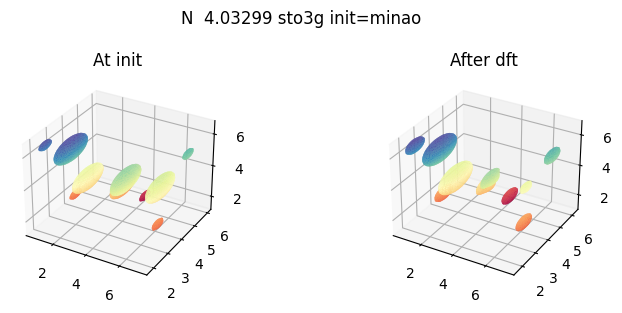

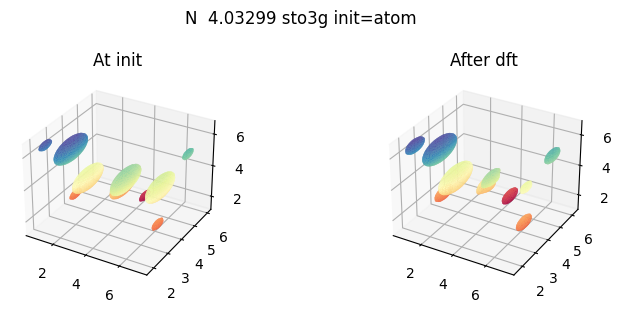

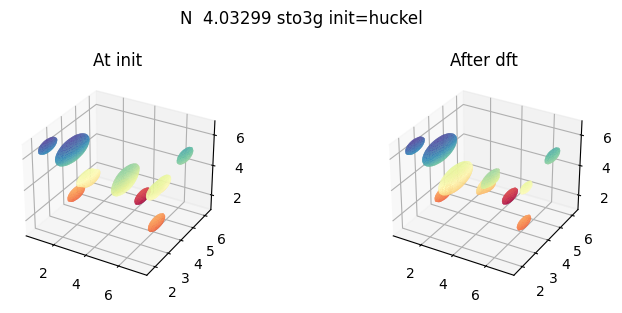

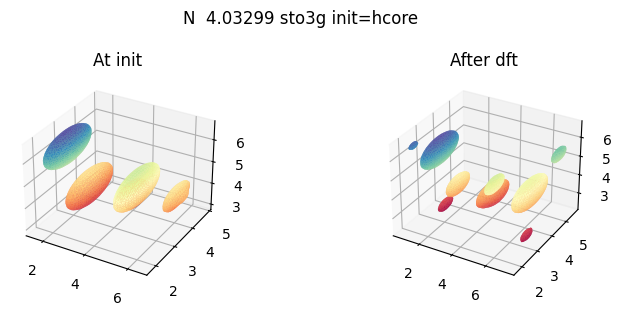

In [107]:
plot_string(string, basis="sto3g", init="minao")
plot_string(string, basis="sto3g", init="atom")
plot_string(string, basis="sto3g", init="huckel")
plot_string(string, basis="sto3g", init="hcore")

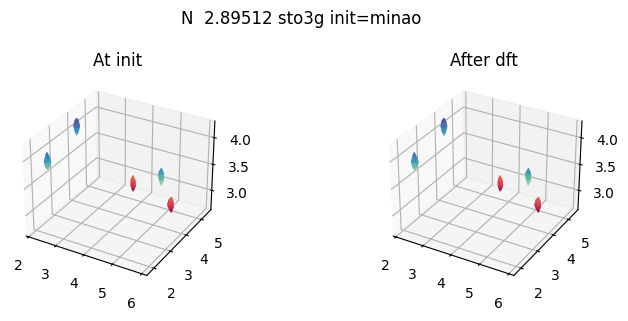

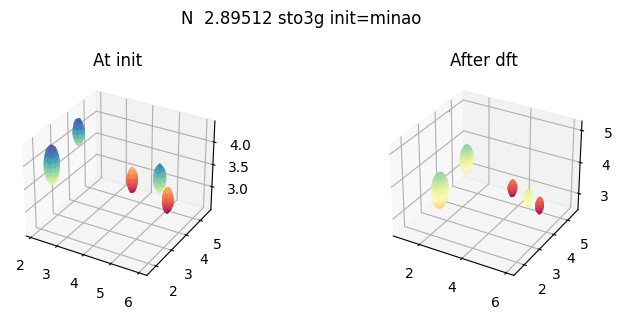

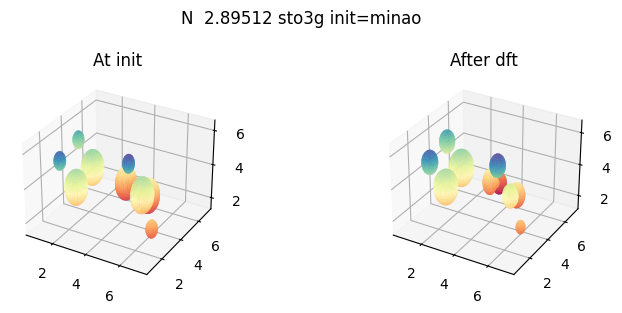

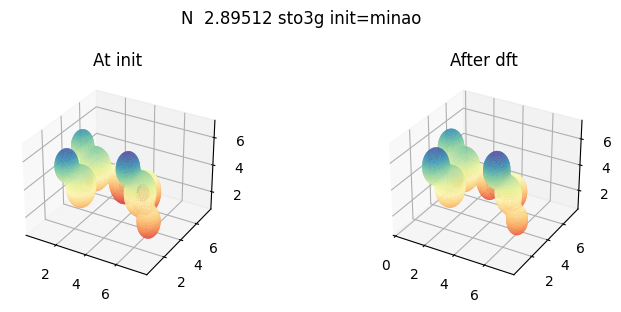

In [123]:
for normalize in [10, 100, 1000, 10000]:
  plot_string(string, basis="sto3g", init="minao", normalize=normalize)

In [110]:
import pandas as pd
smiles = pd.read_parquet("gdb/gdb12/gdb12_sorted.parquet")["smiles"].values # takes ~ 30s to load? 
#print(time.time()-t0)
#print(args.smiles)

angstrom_to_bohr = 1.88973
import re 

def get_atom_string(atoms, locs):
    atom_string = atoms 
    atoms = re.findall('[a-zA-Z][^A-Z]*', atoms)
    str = ""
    for atom, loc in zip(atoms, locs): 
      str += "%s %4f %4f %4f; "%((atom,) + tuple(loc) )
    return atom_string, str 

#if args.gdb == 10: args.smiles = [a.split("\t")[0] for a in open("gdb/gdb11_size10.smi", "r").read().split("\n")]
#if args.gdb == 10: args.smiles = [a for a in open("gdb/gdb11_size10_sorted.csv", "r").read().split("\n")]
##if args.gdb == 9:  args.smiles = [a.split("\t")[0] for a in open("gdb/gdb11_size09.smi", "r").read().split("\n")]
#if args.gdb == 9:  args.smiles = [a for a in open("gdb/gdb11_size09_sorted.csv", "r").read().split("\n")]
#if args.gdb == 7:  args.smiles = [a for a in open("gdb/gdb11_size07_sorted.csv", "r").read().split("\n")]
#if args.gdb == 8:  args.smiles = [a for a in open("gdb/gdb11_size08_sorted.csv", "r").read().split("\n")]
#if args.gdb == 5:  args.smiles = [a.split("\t")[0] for a in open("gdb/gdb11_size05.smi", "r").read().split("\n")]
#smiles = [a for a in open("gdb/gdb11_size05_sorted.csv", "r").read().split("\n")]

smile = smiles[123]

#atoms = [a for a in list(smile) if a == "C" or a == "N" or a == "O" or a == "F"] #+ ["H"]
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import AllChem
b = Chem.MolFromSmiles(smile)
b = Chem.AddHs(b)  # perhaps more numerically stable wiht the H's? e.g. energy may be lower?;; main problem with this is memory? 
atoms = [atom.GetSymbol() for atom in b.GetAtoms()]

AllChem.EmbedMolecule(b) # hypothesis: adding Hs on average increase energy => increase numerror, but, removes extreme cases? 
# does look like that!  main problem of more Hs is increased memory consumption, so if we fix that it looks pretty good! 

#locs = np.concatenate( (b.GetConformer().GetPositions(), np.ones((1,3))*4), axis=0)
locs = b.GetConformer().GetPositions() * angstrom_to_bohr
atom_string, string = get_atom_string(" ".join(atoms), locs)

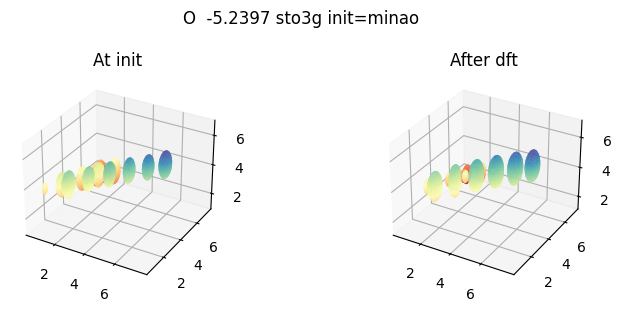

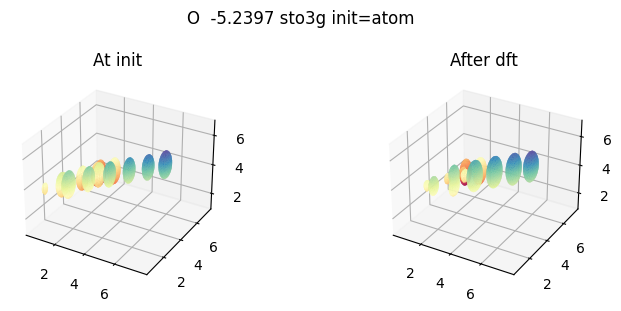

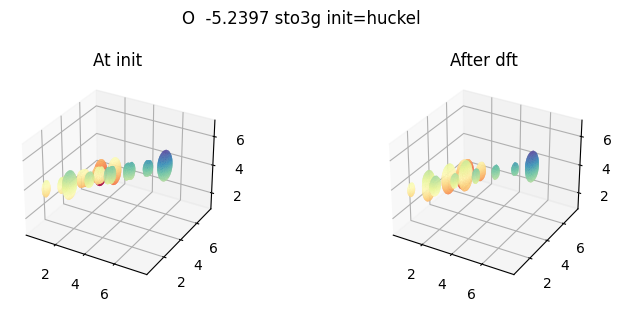

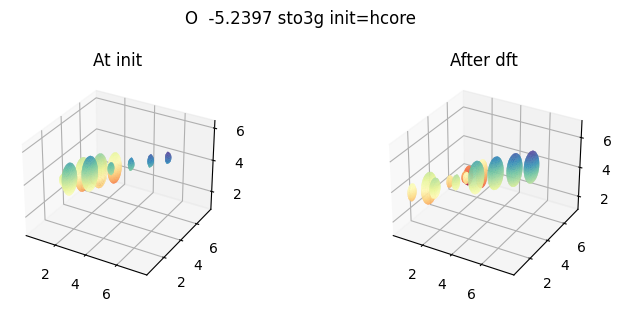

In [111]:
plot_string(string, basis="sto3g", init="minao")
plot_string(string, basis="sto3g", init="atom")
plot_string(string, basis="sto3g", init="huckel")
plot_string(string, basis="sto3g", init="hcore")

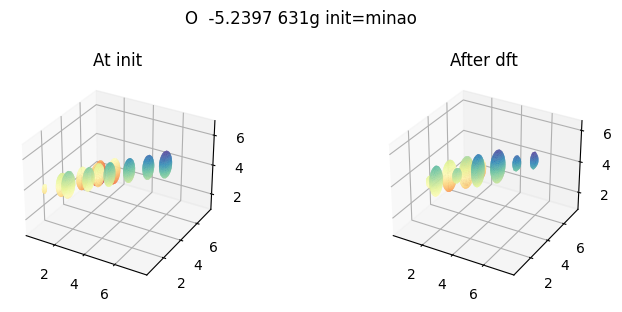

In [112]:
plot_string(string, basis="631g", init="minao")
#plot_string(string, basis="631g", init="atom")
#plot_string(string, basis="631g", init="huckel")
#plot_string(string, basis="631g", init="hcore")

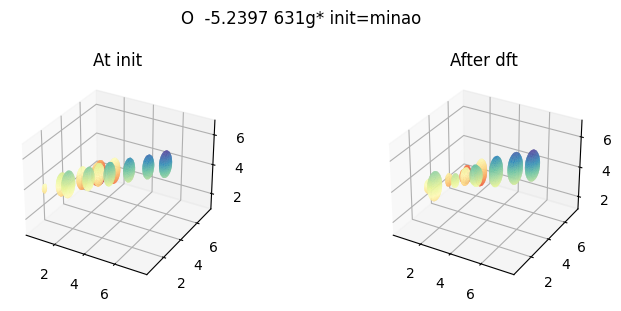

In [113]:
plot_string(string, basis="631g*", init="minao")
#plot_string(string, basis="631g*", init="atom")
#plot_string(string, basis="631g*", init="huckel")
#plot_string(string, basis="631g*", init="hcore")

In [ ]:
# neural network density models are going to be better; train those to predict init_dm final dm. 